##### import library

In [1]:
# ---- Standard Libraries ----
import os
import random
import pickle
import base64

# ---- Numerical and Scientific Computing ----
import numpy as np
import pandas as pd

# ---- Plotting and Display ----
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display, HTML

# ---- Machine Learning: Scikit-learn ----
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---- Statistics ----
from scipy.stats import pearsonr

# ---- Deep Learning: TensorFlow / Keras ----
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# ---- R Integration (rpy2) ----
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.vectors import StrVector
import rpy2.robjects.packages as rpackages
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, StrVector
from pdf2image import convert_from_path
from IPython.display import display

# ---- PDF/Image Handling ----
from pdf2image import convert_from_path


2025-08-05 11:13:37.667623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 11:13:37.667680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 11:13:37.668667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 11:13:37.673800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 11:13:38.314727: W tensorflow/compiler/tf2

##### Limit GPU usage

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set a cap (in MB) for the first GPU, e.g., 4096 MB = 4 GB
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2000)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


2025-08-05 11:13:40.222441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2000 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


##### Set the seed

In [3]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42, enable_tf_determinism=True):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # For CPU-only reproducibility, optional

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    if enable_tf_determinism:
        try:
            tf.config.experimental.enable_op_determinism(True)
        except Exception:
            pass
my_seed = 19
# Usage:
set_seed(my_seed)


##### Load data

In [4]:
# Load data
file_path = fasta_file_path = "../../../data/kgain_all_population_wt.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file '{file_path}' was not found. Please upload the file to the correct path.")

df = pd.read_csv(file_path)[['ref_flank_seq', 'ALT', 'wild_type_kGain']]

##### Delete dupliate entry

In [5]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df

,ref_flank_seq,ALT,wild_type_kGain
0,GTCCACCCGCCGTATTGCG,T,-8.764470
1,ACGGAACGGCTGGCCATTA,T,-11.203187
2,CCAATATCAACATTGTCGC,G,-2.844573
3,CCGGCTCCGGTCGCCAATG,A,-9.244451
4,GCAGCGTATAGCGCGTGGT,G,7.647503
...,...,...,...
34386,TTTTTGAAACGCTCACCGC,T,-4.515558
34387,CGATTTCGAGGCCGAGAAT,A,-1.791759
34388,AGAACTGGTACCGCTGTTA,G,7.409069
34389,GTGTTTGGTCGCGAAGATT,T,-8.417367


##### One-hot encode allele

In [7]:
base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

##### Helper function

In [8]:
def one_hot_encode(seq, base_to_int={'A': 0, 'C': 1, 'G': 2, 'T': 3}):
    """
    One-hot encode a DNA sequence using a provided base-to-index mapping.

    Parameters
    ----------
    seq : str
        A DNA sequence consisting of nucleotide characters (e.g., 'A', 'C', 'G', 'T').
    base_to_int : dict
        A dictionary mapping each base character to an integer index (0 to 3).
        Example: {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(seq), 4), where each row is the one-hot encoded
        representation of the corresponding nucleotide in the input sequence.
        Unrecognized bases will result in a row of zeros.

    Notes
    -----
    - The function assumes exactly 4 output classes corresponding to the columns of the 
      returned array. Extend manually if more bases (e.g., 'N') are needed.
    - Input characters not in `base_to_int` will be encoded as all-zero vectors.
    """
    encoded = np.zeros((len(seq), 4))
    for i, base in enumerate(seq):
        if base in base_to_int:
            encoded[i, base_to_int[base]] = 1
    return encoded


In [9]:
def encode_ref_minus_alt(ref_seq, alt_allele, mut_idx=9):

    """
    Encode a reference DNA sequence into one-hot vectors and subtract the one-hot encoding 
    of the alternate allele at a specified mutation index.

    Parameters
    ----------
    ref_seq : str
        The reference DNA sequence (e.g., "ACGTGACCTGA").
    alt_allele : str
        The alternate allele (a single nucleotide: 'A', 'C', 'G', or 'T') to compare against 
        the reference at the mutation site.
    mut_idx : int, optional
        The index (0-based) in the reference sequence where the mutation occurs. Default is 9.

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(ref_seq), 4), where each row is the one-hot encoding of 
        the nucleotide at that position. At the mutation index, the value is 
        one_hot(ref_base) - one_hot(alt_allele).

    Notes
    -----
    This encoding emphasizes the difference between the reference and the alternate allele 
    at the mutation site, and keeps other positions unchanged.
    """
    arr = []
    for i, base in enumerate(ref_seq):
        if i == mut_idx:
            ohe = np.array(np.array(one_hot_encode(base) - one_hot_encode(alt_allele)))
        else:
            ohe = np.array(one_hot_encode(base))
        arr.append(ohe)
    return np.array(arr)


In [10]:
def encode_row(row):

    """
    Encode a single row of a DataFrame by computing the one-hot encoded difference 
    between the reference nucleotide and the alternate allele at the mutation site.

    Parameters
    ----------
    row : pandas.Series
        A row from a DataFrame containing at least the following fields:
        - 'ref_flanking_regions': str, the reference DNA sequence with the variant at center.
        - 'Alt_allele': str, the alternate base at the mutation site.

    Returns
    -------
    np.ndarray
        A 2D NumPy array of shape (len(ref_seq), 4), representing one-hot encodings of 
        the reference sequence. At the mutation index, the encoding is:
        one_hot(ref_base) - one_hot(alt_allele)
    
    Notes
    -----
    - Assumes the variant is centered in the `ref_flanking_regions` string.

    """
    ref_seq = row['ref_flank_seq']
    alt_allele = row['ALT']
    mut_idx = len(ref_seq) // 2  # As variant is centered
    return encode_ref_minus_alt(ref_seq, alt_allele, mut_idx)




In [11]:
base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

##### Parameters

In [12]:
def focal_regression_loss(gamma=2.0):
    """
    Focal Loss for Regression (without alpha parameter).

    Args:
        gamma (float): Focusing parameter.

    Returns:
        A callable Keras loss function (a closure).
    """
    def loss(y_true, y_pred):
        y_pred = tf.cast(y_pred, y_true.dtype)
        err = tf.abs(y_true - y_pred)
        err = tf.maximum(err, keras.backend.epsilon())
        factor = tf.pow(err, gamma)
        base = err
        
        # Weighted focal loss (per-sample or per-element) - alpha removed, so it's just factor * base
        fl = factor * base
        
        return tf.reduce_mean(fl)
    
    loss.__name__ = f"focal_regression_loss_g{gamma}" # Adjusted name after removing alpha
    return loss


In [13]:
ATTN_SEQ_LEN = 19
ATTN_ONEHOT_DIM = 4
ATTN_EMB_DIM = 32
ATTN_NUM_HEADS = 4
ATTN_FF_DIM = 32
ATTN_NUM_LAYERS = 2
ATTN_DROPOUT_RATE = 0.1
gamma = 2

In [14]:

def build_attention_regressor(
    seq_len=ATTN_SEQ_LEN, onehot_dim=ATTN_ONEHOT_DIM, emb_dim=ATTN_EMB_DIM,
    num_heads=ATTN_NUM_HEADS, ff_dim=ATTN_FF_DIM, num_layers=ATTN_NUM_LAYERS,
    dropout_rate=ATTN_DROPOUT_RATE, return_attention=False, seed=None
):
    inp = keras.Input(shape=(seq_len, onehot_dim), name="seq_onehot_input")
    x = layers.Dense(
        emb_dim,
        kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros()
    )(inp)
    pos_idx = tf.range(seq_len)[tf.newaxis, :]
    pos_emb = layers.Embedding(
        input_dim=seq_len,
        output_dim=emb_dim,
        embeddings_initializer=keras.initializers.GlorotUniform(seed=seed)
    )(pos_idx)
    pos_emb = tf.squeeze(pos_emb, axis=0)
    x = x + pos_emb
    x = layers.Dropout(dropout_rate, seed=seed)(x)
    attention_scores_outputs = []
    for i in range(num_layers):
        attn_layer = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=emb_dim,
            name=f"my_attention_{i}",
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )
        attn_out, attn_scores = attn_layer(x, x, return_attention_scores=True)
        attention_scores_outputs.append(attn_scores)
        attn_out = layers.Dropout(dropout_rate, seed=seed)(attn_out)
        x = layers.Add()([x, attn_out])
        x = layers.LayerNormalization()(x)
        ff = layers.Dense(
            ff_dim,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )(x)
        ff = layers.Dropout(dropout_rate, seed=seed)(ff)
        ff = layers.Dense(
            emb_dim,
            kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
            bias_initializer=keras.initializers.Zeros()
        )(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    out = layers.Dense(
        1,
        activation='linear',
        name="regression_output",
        kernel_initializer=keras.initializers.GlorotUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros()
    )(x)
    if return_attention:
        model = keras.Model(inp, [out] + attention_scores_outputs)
    else:
        model = keras.Model(inp, out)
    return model


In [15]:
# # ---- Inference: reload, extract prediction and attention ----
attn_model = build_attention_regressor(return_attention=True, seed=my_seed)
attn_model(tf.zeros((1, ATTN_SEQ_LEN, ATTN_ONEHOT_DIM)))  # build model variables
attn_model.load_weights("attn_regressor_focal.weights.h5")


2025-08-05 11:13:40.632499: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [16]:
lab_df = pd.read_csv("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/figure/main figures/fig4/Lab_ltte_with_af1.csv")


In [17]:
lab_df = pd.read_csv("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/figure/main figures/fig4/Lab_ltte_with_af1.csv")
# lab_ltte_df
lab_df = lab_df[["ref_flank", "REF", "POS", "ALT", 'kgain_wt', "GENE"]].dropna().drop_duplicates()
lab_df.reset_index(inplace=True, drop=True)

In [18]:
lab_df = pd.read_csv("/home/abhishekh/Downloads/Oligo_Promotion-main(8) (1)/Oligo_Promotion-main/figure/main figures/fig4/Lab_ltte_with_af1.csv")
# lab_ltte_df
lab_df = lab_df[["ref_flank", "REF", "POS", "ALT", 'kgain_wt', "GENE"]].dropna().drop_duplicates()
lab_df.reset_index(inplace=True, drop=True)
lab_df.columns = ['ref_flank_seq', "REF", "POS", 'Alt_allele', 'kgain_wt', "GENE"]
lab_df.rename(columns = {"Alt_allele": "ALT" }, inplace=True)
lab_df["ref_flank_seq"] = lab_df["ref_flank_seq"].apply(lambda x: x[1:-1])
X_encoded_lab = np.stack(lab_df.apply(encode_row, axis=1))
X_encoded_lab = X_encoded_lab.reshape(-1, 19, 4)
y_lab = lab_df['kgain_wt'].values.astype(np.float32)


In [19]:
df_long_all = None

In [20]:
# import numpy as np
# import pandas as pd
# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri, StrVector
# from pdf2image import convert_from_path
# from IPython.display import display

# pandas2ri.activate()

# tmp = lab_df[lab_df["POS"]==3471972].reset_index(drop=True)

# for sample_idx in range(tmp.shape[0]):
#     print(tmp.loc[sample_idx, "GENE"])

#     print(tmp.loc[sample_idx, "kgain_wt"])
#     ref_seq = tmp.loc[sample_idx, "ref_flank_seq"]
#     if isinstance(ref_seq, str):
#         ref_seq = list(ref_seq)
#     X_encoded_lab_tmp = encode_ref_minus_alt(ref_seq=ref_seq, alt_allele=tmp.loc[sample_idx, "ALT"], mut_idx=9)

#     # Predict - always single sample, so index 0!
#     pred, *attn_scores = attn_model.predict(X_encoded_lab_tmp.reshape(-1, 19, 4))
#     print(pred)

#     num_layers = len(attn_scores)
#     num_heads = attn_scores[0].shape[1]
#     seq_len = attn_scores[0].shape[2]

#     df_list = []
#     for layer in range(num_layers):
#         arr = attn_scores[layer][0]  # Always batch index 0 for predict
#         for head in range(num_heads):
#             df = pd.DataFrame(arr[head])
#             df = df.reset_index().melt(id_vars="index", var_name="Key", value_name="Attention")
#             df = df.rename(columns={'index': 'Query'})
#             df["Head"] = head + 1
#             df["Layer"] = layer + 1
#             df_list.append(df)
#     df_long_all = pd.concat(df_list, axis=0, ignore_index=True)

#     df_long_all["KeyNuc"] = df_long_all["Key"].map(lambda x: ref_seq[int(x)])
#     df_long_all["QueryNuc"] = df_long_all["Query"].map(lambda x: ref_seq[int(x)])
#     key_nuc_labels = ref_seq
#     query_nuc_labels = ref_seq

#     # Pass to R
#     ro.globalenv['attn_long_all'] = ro.conversion.py2rpy(df_long_all)
#     ro.globalenv['key_nuc_labels'] = StrVector(key_nuc_labels)
#     ro.globalenv['query_nuc_labels'] = StrVector(query_nuc_labels)
#     ro.globalenv['num_heads'] = num_heads
#     ro.globalenv['num_layers'] = num_layers
#     ro.globalenv['pdf_filename'] = f"all_attention_maps_{sample_idx+1}.pdf"


#     ro.r('''
#     library(ggplot2)
#     library(scico)


#     seq_len <- length(key_nuc_labels)
#     highlight_idx <- 9  # Python passes 0-based for position 10

#     # Build custom x labels with <span> for color
#     custom_x_labels <- key_nuc_labels
#     custom_x_labels[highlight_idx+1] <- sprintf("<span style='color:red;font-weight:bold;'>%s</span>", key_nuc_labels[highlight_idx+1])

#     # Likewise for y, but optional
#     custom_y_labels <- query_nuc_labels

#     attn_long_all$Key <- as.integer(attn_long_all$Key)
#     attn_long_all$Query <- as.integer(attn_long_all$Query)
#     attn_long_all$Head <- factor(attn_long_all$Head)
#     attn_long_all$Layer <- factor(attn_long_all$Layer)

#     highlight_idx <- 9 # or 10 for 1-based, adjust as per your tick numbering

#     p <- ggplot(attn_long_all, aes(x = Key, y = Query, fill = Attention)) +
#     geom_tile(color = "white", size = 0.05) +
#     scale_fill_scico(palette = "oleron", direction = -1, name = "Attention") +
#     # Add a vertical line at the 9th tick (adjust +0.5 if needed)
#     geom_vline(xintercept = highlight_idx, color = "red", linetype = "dashed", size = 0.6) +
#     scale_x_continuous(
#         breaks = 0:(seq_len-1),
#         labels = key_nuc_labels,
#         expand = expansion(mult = c(0, 0))
#     ) +
#     scale_y_continuous(
#         breaks = 0:(seq_len-1),
#         labels = query_nuc_labels,
#         expand = expansion(mult = c(0, 0))
#     ) +
#     facet_grid(Layer ~ Head, labeller = label_both, switch = "y") +
#     labs(
#         x = "Key (nucleotide)", y = "Query (nucleotide)",
#         title = "Attention Maps: All Layers and Heads"
#     ) +
#     theme_minimal(base_family = "Helvetica") +
#     theme(
#         strip.text = element_text(size = 10, face = "bold", color = "#313366"),
#         plot.title = element_text(size = 10, face = "bold", hjust = 0.5, margin = margin(b = 10)),
#         axis.text.x = element_text(size = 9, angle = 0, hjust = 1, color = "black", face = "bold"),
#         axis.text.y = element_text(size = 9, color = "black", face = "bold"),
#         axis.title = element_text(size = 9, face = "bold"),
#         legend.position = "bottom",
#         legend.text = element_text(size = 12, face = "bold"),
#         panel.grid = element_blank(),
#         panel.border = element_rect(color = "gray40", fill = NA, linewidth = 0.7)
#     )
#         ggsave(pdf_filename, p,
#         width = 4*num_heads, height = 4.3*num_layers, units = "in", dpi = 300)
#     ''')

#     # Show just the first page (for notebook; you can skip if running as a batch script)
#     pages = convert_from_path(f"all_attention_maps_{sample_idx+1}.pdf", dpi=300)
#     display(pages[0])
#     # break


In [21]:
# lab_df

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------- CONFIG -------------
mut_idx = 9  # mutated position
seq_len = 19
all_attn_scores = []  # will collect (num_samples, num_layers, num_heads, seq_len, seq_len)

# ----------- COLLECT ATTENTION FOR ALL SAMPLES ----------
for sample_idx in range(lab_df.shape[0]):
    ref_seq = lab_df.loc[sample_idx, "ref_flank_seq"]
    if isinstance(ref_seq, str):
        ref_seq = list(ref_seq)
    X_encoded_lab_tmp = encode_ref_minus_alt(
        ref_seq=ref_seq, alt_allele=lab_df.loc[sample_idx, "ALT"], mut_idx=mut_idx
    )
    pred, *attn_scores = attn_model.predict(X_encoded_lab_tmp.reshape(-1, seq_len, 4))
    # attn_scores: list of arrays, one per layer, each (1, num_heads, seq_len, seq_len)
    attn_per_layer = [a.squeeze(axis=0) for a in attn_scores]  # shape (num_heads, seq_len, seq_len)
    all_attn_scores.append(np.stack(attn_per_layer))  # shape (num_layers, num_heads, seq_len, seq_len)
# all_attn_scores: list of (num_layers, num_heads, seq_len, seq_len)

all_attn_scores = np.stack(all_attn_scores)  # shape: (num_samples, num_layers, num_heads, seq_len, seq_len)
num_samples, num_layers, num_heads, seq_len, _ = all_attn_scores.shape

# --------- COMPUTE MEAN ATTENTION PER LAYER & HEAD (per key position) ----------
mean_attention_lhk = all_attn_scores.mean(axis=(0, 3))  # (num_layers, num_heads, seq_len)
positions = np.arange(seq_len)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


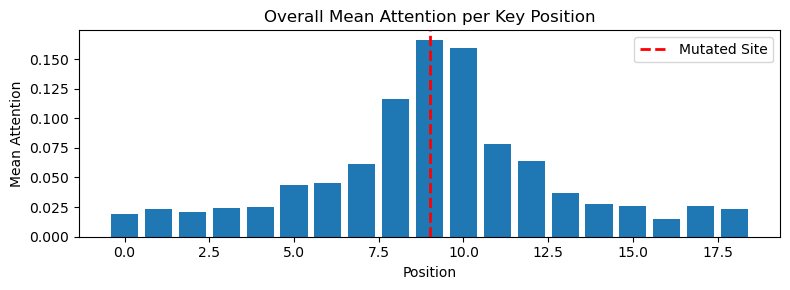

In [23]:
# --------- (OPTIONAL) OVERALL ATTENTION PROFILE ----------
overall_mean_attention = all_attn_scores.mean(axis=(0, 1, 2, 3))  # (seq_len,)
plt.figure(figsize=(8, 3))
plt.bar(positions, overall_mean_attention)
plt.axvline(mut_idx, color='red', linestyle='--', lw=2, label='Mutated Site')
plt.title("Overall Mean Attention per Key Position")
plt.xlabel("Position")
plt.ylabel("Mean Attention")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import numpy as np

# Example: positions = np.arange(seq_len)
# Example: overall_mean_attention = np.array([...])

# Construct DataFrame
df_plot = pd.DataFrame({
    "Position": positions,
    "MeanAttention": overall_mean_attention
})
df_plot["Highlight"] = (df_plot["Position"] == mut_idx)


In [25]:
# df_plot

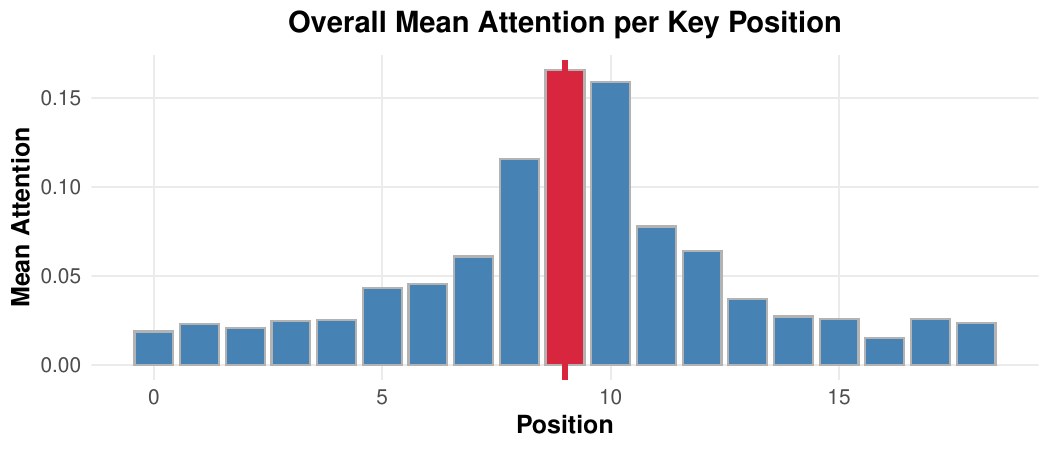

In [26]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

pandas2ri.activate()
ro.globalenv['df_plot'] = ro.conversion.py2rpy(df_plot)
ro.globalenv['mut_idx'] = mut_idx

ro.r('''
library(ggplot2)
library(scico)
# library(ggtext)

p <- ggplot(df_plot, aes(x=Position, y=MeanAttention, fill=Highlight)) +
    geom_col(width=0.85, color="gray70", show.legend=FALSE) +
    geom_vline(xintercept = mut_idx, color = "#D7263D", linetype = "dashed", linewidth = 1.2) +
    scale_fill_manual(values=c("FALSE"="#4682b4", "TRUE"="#D7263D")) +
    labs(
        title = "Overall Mean Attention per Key Position",
        x = "Position",
        y = "Mean Attention"
    ) +
    theme_minimal(base_family = "Helvetica") +
    theme(
        plot.title = element_text(size=14, face="bold", hjust=0.5, margin=margin(b=8)),
        axis.title = element_text(size=12, face="bold"),
        axis.text = element_text(size=10),
        panel.grid.minor = element_blank()
    )

ggsave("mean_attention_barplot.pdf", p, width=7, height=3, units="in", dpi=300)
# print(p)
''')
from pdf2image import convert_from_path
from IPython.display import display
pages = convert_from_path("mean_attention_barplot.pdf", dpi=150)
display(pages[0])